Kilde: https://python.plainenglish.io/how-to-improve-investment-portfolio-with-rebalancing-strategy-in-python-a58841ee8b5e

In [282]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os as os

## Har antaget at vores prediction ligger i kolonnen 'Close'
## Denne funktions output er et dataset med en kolonne for hver aktiv og deres afkast mellem hver dag
## begin_date skal svare til dagen før vi predikter.

def afkast(data, begin_CET, pred_true): #predict data
    
    stock_returns = pd.DataFrame()
    
    df_uniq = pd.DataFrame({'CET' : np.sort(pd.unique(data['CET']), axis = 0)})
    for name in pd.unique(data['Name']):
        uniq = pd.unique(data[data['Name'] == name]['CET'])
        uniq = pd.DataFrame({'CET' : uniq})
        df_uniq = df_uniq.merge(uniq, how = 'inner', on = ['CET'])
    
    if(pred_true == 'TRUE' or pred_true == 'true' or pred_true == 'True'):
    
        for name in pd.unique(data['Name']):
            df_name = data[data['Name'] == name].reset_index(drop = True)
            df_sub = df_name.merge(df_uniq, how = 'inner', on = ['CET'])
            idx = df_sub[df_sub['CET'] == begin_CET].index[0]
            df = df_sub.iloc[idx:,:].reset_index(drop = True)
            
            df['Predictions'][0] = df['Close'][0]
            
            stock_returns[name] = np.array(df['Predictions'].pct_change())
    
        stock_returns = stock_returns.dropna() # drop the first row.'
        
    else:
        
        for name in pd.unique(data['Name']):
            df_name = data[data['Name'] == name].reset_index(drop = True)
            df_sub = df_name.merge(df_uniq, how = 'inner', on = ['CET'])
            idx = df_sub[df_sub['CET'] == begin_CET].index[0]
            df = df_sub.iloc[idx:,:].reset_index(drop = True)
            
            stock_returns[name] = np.array(df['Close'].pct_change())
    
        stock_returns = stock_returns.dropna() # drop the first row.'
        
    return stock_returns




## Historical volatility
def volatility(data, begin_CET, pred_true): #predict data, need CET, Name, Close, pred
    
    df_vol = pd.DataFrame()
    
    #date = begin_CET
    #year = date.dt.year.values[0]
    #new_year = str(year-1)
    #date = new_year + date[4:]
    
    df_uniq = pd.DataFrame({'CET' : np.sort(pd.unique(data['CET']), axis = 0)})
    for name in pd.unique(data['Name']):
        uniq = pd.unique(data[data['Name'] == name]['CET'])
        uniq = pd.DataFrame({'CET' : uniq})
        df_uniq = df_uniq.merge(uniq, how = 'inner', on = ['CET'])
    
    if(pred_true == 'TRUE' or pred_true == 'true' or pred_true == 'True'):
        annual_business_days=200        
        for name in pd.unique(data['Name']):
            df_name = data[data['Name'] == name].reset_index(drop=True)
            df_sub = df_name.merge(df_uniq, how = 'inner', on = ['CET'])
            NAN = df_sub['Predictions'].isnull()
            idx = [i for i, x in enumerate(NAN) if x][-1]
            #idx = df_name[df_name['CET'] == date].index.tolist()
            df = df_sub.iloc[(idx-annual_business_days):,:].reset_index(drop=True)
            vol = []
        
            for n in np.arange(df.shape[0]-annual_business_days-1):
                df_close = df['Close'][n+1:n+annual_business_days]  # if we want vol for 01/01-2022, then we want to start at 02/01-2021
                df_pred = df['Predictions'][n+annual_business_days+1]
                df_merge = np.concatenate([df_close, pd.Series(df_pred)])
                vol.append(df_merge.std() / np.sqrt(annual_business_days))
        
            df_vol[name] = np.array(vol)
            
    else:
        annual_business_days = 200
        for name in pd.unique(data['Name']):
            df_name = data[data['Name'] == name].reset_index(drop=True)
            df_sub = df_name.merge(df_uniq, how = 'inner', on = ['CET'])
            NAN = df_sub['Predictions'].isnull()
            idx = [i for i, x in enumerate(NAN) if x][-1]
            #idx = df_name[df_name['CET'] == date].index.tolist()
            df = df_sub.iloc[idx-annual_business_days:,:].reset_index(drop=True)
    
            vol = []
            
        
            for n in np.arange(df.shape[0]-annual_business_days-1):
                df_close = df[n+1:n+annual_business_days+1]  # if we want vol for 01/01-2022, then we want to start at 02/01-2021
                vol.append(df_close['Close'].std() / np.sqrt(annual_business_days))
        
            df_vol[name] = np.array(vol)
        
        
        
    return df_vol



Denne funktion fortæller de bedste afkast og vælger de 'numStocks' bedste. Tanken er så, at man investere ligelidt mellem dem, og så sælger dem alle minuttet/timen/dagen efter. Herefter gør vi det samme igen. 

* data: alle afkast værdier. 
* numAssets: Antallet af aktiver vi vil investere i hver dag. 
* numRev: antallet af de valgte aktiver vi vil fjerne. Kan ikke være >numAssets

In [250]:
def portfolio(data, numAssets, numRev, data_vol): ## Afkast data og Vol data
    
    df = data.copy()
    assets_used_daliy = pd.DataFrame()
    selected_assets = []
    avg_daily_ret = [0]
    
    for i in range(len(df)):
        if len(selected_assets ) > 0:
            avg_daily_ret.append(df[selected_assets].iloc[i,:].mean()) # Assumes we invest equally in the selected assets
            bad_assets = df[selected_assets].iloc[i,:].sort_values(ascending=True)[:numRev].index.values.tolist()
            selected_assets  = [t for t in selected_assets if t not in bad_assets]
            
        fill = numAssets - len(selected_assets)
        
        vol = data_vol.iloc[i,:]
        vol_norm = (vol - min(vol)) / (max(vol) - min(vol))  # values between 0 and 1. If used, use below as return_vol
        return_vol = df.iloc[i,:]/(1+vol_norm)
        
        #return_vol = df.iloc[i,:]/(vol)
        
        new_picks = return_vol.sort_values(ascending=False)[:fill].index.values.tolist()
        selected_assets  = selected_assets  + new_picks
        print(selected_assets)
        assets_used_daliy[i] = selected_assets
        
    returns_df = pd.DataFrame(np.array(avg_daily_ret),columns=["daily_returns"])
    return returns_df, assets_used_daliy.T 

In [267]:
def cagr(data):  # portfolio data
    df = data.copy()
    df['cumulative_returns'] = (1 + df['daily_returns']).cumprod()
    trading_days = len(df)
    n = len(df)/ trading_days
    cagr = (df['cumulative_returns'][len(df)-1])**(1/n) - 1
    return cagr


def maximum_drawdown(data):
    df = data.copy()
    df['cumulative_returns'] =  (1 + df['daily_returns']).cumprod()
    df['cumulative_max'] = df['cumulative_returns'].cummax()
    df['drawdown'] = df['cumulative_max'] - df['cumulative_returns']
    df['drawdown_pct'] = df['drawdown'] / df['cumulative_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd


def calmar_ratio(data, rf):
    df = data.copy()
    calmar = (CAGR(df) - rf) / maximum_drawdown(df)
    return calmar




Kilde til Calmar Ratio: https://python.plainenglish.io/i-used-python-to-develop-investment-portfolio-performance-indicators-c52a7671d49b
        
Søg efter 'Calmar'

In [272]:
a = pd.DataFrame({'A' : [1,2,3,4,5], 'B': [1,2,3,4,5]})
a.pct_change()

a.cumprod()

,A,B
0,1,1
1,2,2
2,6,6
3,24,24
4,120,120


In [285]:
(1+np.array(returns_true.mean(axis=1))).cumprod()
np.array(returns_true.mean(axis=1))

array([ 0.00049387,  0.01618638,  0.00291036,  0.00636234,  0.00940642,
        0.00305176, -0.00821769,  0.00401957, -0.01086959,  0.00189202,
       -0.01098462, -0.00591243,  0.0091975 , -0.00380907, -0.00749897,
        0.01845078,  0.01131283, -0.02119437,  0.01228968, -0.02909324,
        0.04991177,  0.01243288, -0.00443018,  0.0272367 , -0.00761916,
        0.00215852, -0.00853864,  0.0158724 , -0.00885615,  0.00723193,
        0.0155795 ,  0.00456051,  0.01115903, -0.01947622, -0.00053666,
       -0.02562565, -0.00930965,  0.00144722, -0.02274396,  0.00207143,
        0.01810308,  0.00284627, -0.01668225, -0.01288503,  0.00073834,
       -0.0048557 ,  0.01173096,  0.00802646,  0.00436333, -0.01188583,
       -0.01055211,  0.01174664, -0.00200834, -0.01381614,  0.00798944,
        0.01046632, -0.01019676, -0.00655835,  0.00985171,  0.01480665,
        0.00332408, -0.00234663,  0.00341967,  0.01254859, -0.00376382,
       -0.01066186,  0.00769625,  0.00499781,  0.00171214,  0.00

In [268]:
pd.options.mode.chained_assignment = None  # default='warn'

#os.chdir(r"C:\Users\Bruger\Documents\Google_Drev_data\SwissData")
#date_cols = ['CET']
#pred_data = pd.read_csv('????.txt', index_col=None, parse_dates=date_cols, engine='python')

## Check that begin_date is the same for all assets
for name in pd.unique(pred_data['Name']):
    df = pred_data[pred_data['Name'] == name].reset_index()
    NAN = df['Predictions'].isnull()
    idx = [i for i, x in enumerate(NAN) if x][-1]
    begin_date = df['CET'][idx]
    print(begin_date)


## Check annual_business_days
for name in pd.unique(pred_data['Name']):
    total_rows = pred_data[pred_data['Name'] == name]
    time = total_rows['CET'].astype(str)
    time = time.str[:4]
    print(name)
    print(time.value_counts())

    

## Pred, the return our prediction say we would get
begin_date = '2020-12-30 23:00:00'
returns_pred = afkast(pred_data, begin_date, 'TRUE')
vol_pred = volatility(pred_data, begin_date, 'TRUE')
rebalanced_portfolio_pred, assets_list = portfolio(returns_pred, 1, 1, vol_pred)


## How we really should invest, if we followed our strategy
returns_true = afkast(pred_data, begin_date, 'FALSE')
vol_true = volatility(pred_data, begin_date, 'FALSE')
#rebalanced_portfolio_true, _  = Portfolio(returns_true, 3, 3, vol_true, 0.5)
benchmark = pd.DataFrame()
benchmark['daily_returns'] = np.array(returns_true.mean(axis=0))


## The return we really get from Pred
real_avg_daily_ret_from_pred_result = [0]
for i in np.arange(returns_true.shape[0]):
    real_avg_daily_ret_from_pred_result.append(returns_true[assets_list.iloc[i,:]].iloc[i,:].mean()) #probably not good
real_df = pd.DataFrame(np.array(real_avg_daily_ret_from_pred_result),columns=["daily_returns"])   



print("Rebalanced Portfolio Performance - How we hope it went")
print("CAGR: " + str(cagr(rebalanced_portfolio_pred)))
print("Maximum Drawdown: " + str(maximum_drawdown(rebalanced_portfolio_pred) ))
print("Calmar Ratio: " + str(calmar_ratio(rebalanced_portfolio_pred, 0.03)))

print("\n")

print("Rebalanced Portfolio Performance - How it really went")
print("CAGR: " + str(cagr(real_df)))
print("Maximum Drawdown: " + str(maximum_drawdown(real_df) ))
print("Calmar Ratio: " + str(calmar_ratio(real_df, 0.03)))

print("\n")

print("Benchmark")
print("CAGR: " + str(cagr(benchmark)))
print("Maximum Drawdown: " + str(maximum_drawdown(benchmark) ))
print("Calmar Ratio: " + str(calmar_ratio(benchmark, 0.03)))

2020-12-30 23:00:00
2020-12-30 23:00:00
2020-12-30 23:00:00
DAX
2020    260
2021    260
2019    258
2016    257
2014    255
2015    255
2017    254
2018    253
2022     86
2013      1
Name: CET, dtype: int64
NASDAQ
2014    259
2015    259
2020    259
2021    259
2016    258
2018    258
2019    258
2017    257
2022     84
Name: CET, dtype: int64
GAS
2015    261
2016    259
2020    259
2014    258
2018    258
2019    258
2021    258
2017    257
2022     84
Name: CET, dtype: int64
['NASDAQ']
['GAS']
['GAS']
['GAS']
['GAS']
['NASDAQ']
['NASDAQ']
['GAS']
['DAX']
['GAS']
['DAX']
['GAS']
['DAX']
['NASDAQ']
['NASDAQ']
['NASDAQ']
['NASDAQ']
['GAS']
['GAS']
['GAS']
['DAX']
['NASDAQ']
['GAS']
['DAX']
['DAX']
['GAS']
['NASDAQ']
['NASDAQ']
['NASDAQ']
['GAS']
['DAX']
['GAS']
['GAS']
['GAS']
['GAS']
['DAX']
['DAX']
['DAX']
['DAX']
['DAX']
['NASDAQ']
['GAS']
['DAX']
['GAS']
['DAX']
['DAX']
['DAX']
['DAX']
['NASDAQ']
['GAS']
['NASDAQ']
['NASDAQ']
['NASDAQ']
['GAS']
['DAX']
['DAX']
['GAS']
['GAS']
['NAS

C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['GAS']
['GAS']
['DAX']
['GAS']
['GAS']
['GAS']
['NASDAQ']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['DAX']
['GAS']
['NASDAQ']
['GAS']
['GAS']
['NASDAQ']
['GAS']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['DAX']
['GAS']
['NASDAQ']
['GAS']
['DAX']
['GAS']
['GAS']
['GAS']
['GAS']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['GAS']
['DAX']
['GAS']
['GAS']
['NASDAQ']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['DAX']
['GAS']
['DAX']
['GAS']
['NASDAQ']
['NASDAQ']
['NASDAQ']
['GAS']
['GAS']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['DAX']
['GAS']
['GAS']
['GAS']
['DAX']
['GAS']
['GAS']
['NASDAQ']
['GAS']
['GAS']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['NASDAQ']
['DAX']
['NASDAQ']
['GAS']
['DAX']
['DAX']
['NASDAQ']
['GAS']
['DAX']
['DAX']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['NASDAQ']
['GAS']
['NASDAQ']
['GAS']
['GAS']
['GAS']
['NASDAQ']
['GAS']
['GAS']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['DAX']
['NASDAQ']
['GAS']
['GAS']
['DAX']
['GAS']
['GAS']
['GAS']
['NASDAQ']
['NASDAQ']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['NASDAQ']
['DAX']
['DAX']
['GAS']
['GAS']
['GAS']
['NASDAQ']
['DAX']
['GAS']
['NASDAQ']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['NASDAQ']
['DAX']
['NASDAQ']
['DAX']
['GAS']
['GAS']
['DAX']
['NASDAQ']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['NASDAQ']
['GAS']
['GAS']
['GAS']
['GAS']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['DAX']
['NASDAQ']
['NASDAQ']
['NASDAQ']
['DAX']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['NASDAQ']
['NASDAQ']
['NASDAQ']
['DAX']
['GAS']
['GAS']
['NASDAQ']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['NASDAQ']
['NASDAQ']
['GAS']
['NASDAQ']
['GAS']
['GAS']
['GAS']
['GAS']
['DAX']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['NASDAQ']
['DAX']
['DAX']
['GAS']
['DAX']
['DAX']
['GAS']
['NASDAQ']
['GAS']
['DAX']
['NASDAQ']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['DAX']
['NASDAQ']
['GAS']
['GAS']
['GAS']
['NASDAQ']
['GAS']
['DAX']
['NASDAQ']
['DAX']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['GAS']
['DAX']
['GAS']
['GAS']
['GAS']
['GAS']
['GAS']
['GAS']
['DAX']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['DAX']
['GAS']
['GAS']
['DAX']
['DAX']
['GAS']
['GAS']
['GAS']
['GAS']
['GAS']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['NASDAQ']
['GAS']
['NASDAQ']
['NASDAQ']
['DAX']
['GAS']
['DAX']
['NASDAQ']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['GAS']
['GAS']
['NASDAQ']
['DAX']
['GAS']
['DAX']
['GAS']
['NASDAQ']
['DAX']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['NASDAQ']
['GAS']
['GAS']
['NASDAQ']
['GAS']
['NASDAQ']
['DAX']
['DAX']
['GAS']
['GAS']
['DAX']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['DAX']
['GAS']
['GAS']
['NASDAQ']
['NASDAQ']
['GAS']
['GAS']
['GAS']
['GAS']
['DAX']
['DAX']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['GAS']
['GAS']
['NASDAQ']
['GAS']
['GAS']
['GAS']
['DAX']
['GAS']
['GAS']
['GAS']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assets_used_daliy[i] = selected_assets
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13440\30937261.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

['GAS']
['GAS']
['NASDAQ']
['DAX']
['GAS']
['DAX']
['GAS']
['GAS']
['GAS']
Rebalanced Portfolio Performance - How we hope it went
CAGR: 1.3446689043710536
Maximum Drawdown: 0.34031045275845695
Calmar Ratio: 3.8631458238050937


Rebalanced Portfolio Performance - How it really went
CAGR: 1.0588202097807589
Maximum Drawdown: 0.25028685639945536
Calmar Ratio: 4.1105642724553295


Benchmark
CAGR: 0.5195922696367483
Maximum Drawdown: 0.1745224132074492
Calmar Ratio: 2.8053260360019525


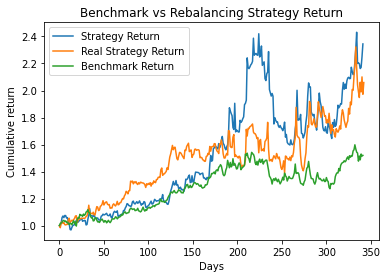

In [284]:
fig, ax = plt.subplots()
plt.plot((1+rebalanced_portfolio_pred).cumprod())
plt.plot((1+real_df).cumprod())
plt.plot((1+benchmark).cumprod())
plt.title("Benchmark vs Rebalancing Strategy Return")
plt.ylabel("Cumulative return")
plt.xlabel("Days")
ax.legend(["Strategy Return", "Real Strategy Return", "Benchmark Return"])